### 1. Exploratory Data Analysis (EDA)

    Statistical Visualizations:
Composition Analysis:

* Pie chart of e-waste by Category

* Bar chart of top 10 brands contributing to e-waste

* Heatmap of toxic components by category

Temporal Trends:

* Line chart of e-waste quantity by Year_of_Purchase (showing aging electronics)

* Seasonal trends in Collection_Date (if date granularity allows)

Geospatial Analysis:

* Choropleth map of e-waste by Location

* Facility distribution map showing Recycling_Facility locations

### 2. Statistical Analysis

    Key Analyses:
Correlation Analysis:

* Correlation matrix heatmap between numeric variables (Weight_kg, Recycled_Price_USD, Carbon_Footprint, etc.)

* Scatter plots with regression lines for key relationships

Hypothesis Testing:

* ANOVA to test if Carbon_Footprint differs significantly across categories

* t-tests to compare recycled prices between different conditions

Time Series Forecasting:

* ARIMA model to predict future e-waste quantities based on historical Collection_Date data

### 3. Machine Learning Approaches

    A. Predictive Modeling:
Price Prediction Model:

* Predict Recycled_Price_USD using Random Forest/XGBoost

* Features: Category, Condition, Weight_kg, Year_of_Purchase, Toxic_Components

* SHAP values for feature importance visualization

Toxicity Classification:

* Binary classifier (Logistic Regression/SVM) to predict presence of Toxic_Components

* ROC curve and confusion matrix visualization

    B. Clustering:
E-Waste Segmentation:

* K-means clustering based on Weight_kg, Carbon_Footprint, Recycled_Price_USD

* 3D scatter plot of clusters with Plotly

Anomaly Detection:

* Isolation Forest to identify unusual e-waste items

* Visualize anomalies in a 2D PCA projection

### 4. Advanced Visual Analytics

Interactive Dashboard Elements:

* Sunburst chart: Category → Brand → Model hierarchy

* Parallel coordinates plot for multidimensional analysis

Carbon Impact Visualization:

* Sankey diagram showing e-waste flow from Location to End_Use with carbon footprint

Toxic Component Analysis:

* Network graph showing relationships between categories and their toxic components



### 5. Specific Research Questions You Can Answer

1. Which factors most influence the recycling price of e-waste?

* Use regression analysis with partial dependence plots

2. How does the carbon footprint vary across different recycling methods?

* Grouped box plots with statistical significance markers

3. Can we predict which items will contain toxic components based on their specifications?

* Classification model with precision-recall curves

4. What are the spatial patterns in e-waste generation and recycling facility distribution?

* GIS mapping with facility capacity vs. local e-waste volume

# ANALYSIS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('e_waste_dataset.csv')
df.head()

,ID,Item_Name,Brand,Model,Category,Year_of_Purchase,Condition,Quantity,Weight_kg,Recycle_Method,Location,Recycling_Facility,Collection_Date,End_Use,Recycled_Price_USD,Toxic_Components,E-Waste_Collector,Carbon_Footprint,Exported_To
0,8636,Washing Machine,Panasonic,Panasonic Model 472,TV,2018,Broken,2,9.84,Manual,London,Facility B,2024-07-24,E-Waste Disposal,163.41,Lead,Green Electronics,2.90,China
1,2686,Air Conditioner,Xiaomi,Xiaomi Model 921,Appliance,2013,Partially Working,1,10.08,Automated,London,Facility A,2024-05-28,Raw Materials,140.15,Mercury,EcoWaste Solutions,16.21,Germany
2,1491,Headphone,LG,LG Model 829,TV,2014,Partially Working,3,14.27,Both,Shanghai,Facility C,2024-04-20,Parts for Electronics,47.65,Cadmium,EcoWaste Solutions,1.05,China
3,2032,Headphone,Sony,Sony Model 723,Appliance,2013,Broken,5,5.42,Manual,Dhaka,Facility C,2024-01-27,Parts for Electronics,26.41,Lead,Green Electronics,18.62,Germany
4,5617,Refrigerator,Dell,Dell Model 751,Mobile,2015,Working,2,9.20,Manual,Shanghai,Facility D,2024-01-04,Parts for Electronics,114.50,Mercury,EcoWaste Solutions,9.36,USA


In [7]:
import pandas as pd
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import time
from tqdm import tqdm

# 1. Load and prepare data
print("\n🔍 Preparing data...")
df = pd.read_csv("e_waste_dataset.csv")  # Use your actual file

# City-to-country mapping — customize as needed
city_to_country = {
    'New York': 'United States',
    'Berlin': 'Germany',
    'Tokyo': 'Japan',
    'London': 'United Kingdom',
    'Paris': 'France',
    'Mumbai': 'India',
    'Shanghai': 'China',
    'Sydney': 'Australia',
    'Toronto': 'Canada',
    'São Paulo': 'Brazil'
}

df['Origin_Country'] = df['Location'].map(city_to_country).fillna(df['Location'])

# 2. Geocoding setup
print("\n🌍 Geocoding locations...")
geolocator = Nominatim(user_agent="ewaste_flow_analysis_numbered")
coordinate_cache = {}

def get_coordinates(place):
    if place in coordinate_cache:
        return coordinate_cache[place]
    
    try:
        location = geolocator.geocode(place)
        time.sleep(1.1)
        if location:
            coords = {'lat': location.latitude, 'lon': location.longitude}
            coordinate_cache[place] = coords
            return coords
        return {'lat': 0, 'lon': 0}
    except Exception as e:
        print(f"⚠️ Could not geocode {place}: {str(e)}")
        return {'lat': 0, 'lon': 0}

# 3. Data aggregation
print("\n📊 Processing data...")
flow_data = df.groupby(['Location', 'Exported_To']).agg(
    Total_Weight=('Weight_kg', 'sum'),
    Shipment_Count=('Weight_kg', 'count')
).reset_index()

origin_list = flow_data['Location'].unique()
destination_list = flow_data['Exported_To'].unique()
all_places = list(origin_list) + list(destination_list)

# Geocode all unique locations
print("⏳ Geocoding progress:")
for place in tqdm(all_places):
    get_coordinates(place)

# 4. Create visualization
print("\n🎨 Creating visualization...")
fig = go.Figure(layout=go.Layout(width=1400, height=800, autosize=False))
color_scale = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Draw flow lines
for i, row in flow_data.iterrows():
    origin = get_coordinates(row['Location'])
    dest = get_coordinates(row['Exported_To'])

    fig.add_trace(go.Scattergeo(
        lon=[origin['lon'], dest['lon']],
        lat=[origin['lat'], dest['lat']],
        mode='lines',
        line=dict(
            width=0.5 + (row['Total_Weight'] / flow_data['Total_Weight'].max() * 5),
            color=color_scale[i % len(color_scale)]
        ),
        opacity=0.7,
        hoverinfo='text',
        text=(f"<b>From:</b> {row['Location']}<br>"
              f"<b>To:</b> {row['Exported_To']}<br>"
              f"<b>Total Weight:</b> {row['Total_Weight']:,.2f} kg<br>"
              f"<b>Shipments:</b> {row['Shipment_Count']}"),
        showlegend=False
    ))

# Add origin points with numbers
fig.add_trace(go.Scattergeo(
    lon=[get_coordinates(loc)['lon'] for loc in origin_list],
    lat=[get_coordinates(loc)['lat'] for loc in origin_list],
    mode='markers+text',
    marker=dict(size=12, color='#4285F4', line=dict(width=2, color='white')),
    text=[f"{i+1}. {loc}" for i, loc in enumerate(origin_list)],
    textposition="top center",
    hoverinfo='text',
    name='Collection Points'
))

# Add destination points with numbers
fig.add_trace(go.Scattergeo(
    lon=[get_coordinates(loc)['lon'] for loc in destination_list],
    lat=[get_coordinates(loc)['lat'] for loc in destination_list],
    mode='markers+text',
    marker=dict(size=12, color='#EA4335', symbol='diamond', line=dict(width=2, color='white')),
    text=[f"{i+1}. {loc}" for i, loc in enumerate(destination_list)],
    textposition="top center",
    hoverinfo='text',
    name='Export Destinations'
))

# Layout configuration
fig.update_layout(
    title=dict(
        text='<b>Global E-Waste Export Flows (Numbered)</b>',
        font=dict(size=24, family="Arial Black"),
        x=0.5,
        xanchor='center'
    ),
    geo=dict(
        scope='world',
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(240, 240, 240)',
        countrycolor='rgb(200, 200, 200)',
        showocean=True,
        oceancolor='rgb(220, 240, 255)',
        showcountries=True,
        showframe=False
    ),
    margin=dict(l=10, r=10, t=80, b=0),
    hoverlabel=dict(
        bgcolor='white',
        font_size=14,
        font_family='Arial'
    ),
    plot_bgcolor='rgb(250, 250, 250)',
    paper_bgcolor='rgb(250, 250, 250)'
)

# 5. Save outputs
print("\n💾 Saving visualization...")
fig.write_html("e_waste_export_flow_numbered.html")
print("✅ Saved as 'e_waste_export_flow_numbered.html'")

print("\n📄 Saving label reference table...")
origin_labels = pd.DataFrame({
    'No.': range(1, len(origin_list) + 1),
    'City': origin_list,
    'Country': [city_to_country.get(loc, loc) for loc in origin_list]
})
origin_labels.to_csv("origin_label_reference.csv", index=False)
print("✅ Saved as 'origin_label_reference.csv'")

print("\n🖥️ Displaying visualization...")
fig.show()



🔍 Preparing data...

🌍 Geocoding locations...

📊 Processing data...
⏳ Geocoding progress:


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


🎨 Creating visualization...

💾 Saving visualization...
✅ Saved as 'e_waste_export_flow_numbered.html'

📄 Saving label reference table...
✅ Saved as 'origin_label_reference.csv'

🖥️ Displaying visualization...


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [8]:
import pandas as pd
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import time
from tqdm import tqdm

# Load CSV data
df = pd.read_csv("e_waste_dataset.csv")

# Initialize geolocator
geolocator = Nominatim(user_agent="ewaste_map_simple")
coordinate_cache = {}

def get_coordinates(place):
    if place in coordinate_cache:
        return coordinate_cache[place]
    try:
        location = geolocator.geocode(place)
        time.sleep(1.1)
        if location:
            coords = {'lat': location.latitude, 'lon': location.longitude}
            coordinate_cache[place] = coords
            return coords
        return {'lat': 0, 'lon': 0}
    except:
        return {'lat': 0, 'lon': 0}

# Get unique locations and destinations
origins = df['Location'].dropna().unique()
destinations = df['Exported_To'].dropna().unique()
all_places = list(set(origins) | set(destinations))

# Geocode all places
print("Geocoding...")
for place in tqdm(all_places):
    get_coordinates(place)

# Create base map
fig = go.Figure()

# Draw flow lines
for _, row in df.iterrows():
    origin = get_coordinates(row['Location'])
    dest = get_coordinates(row['Exported_To'])
    fig.add_trace(go.Scattergeo(
        lon=[origin['lon'], dest['lon']],
        lat=[origin['lat'], dest['lat']],
        mode='lines',
        line=dict(width=1, color='gray'),
        showlegend=False
    ))

# Add numbered origin points
fig.add_trace(go.Scattergeo(
    lon=[get_coordinates(loc)['lon'] for loc in origins],
    lat=[get_coordinates(loc)['lat'] for loc in origins],
    text=[f"{i+1}. {loc}" for i, loc in enumerate(origins)],
    mode='markers+text',
    textposition='top center',
    marker=dict(size=8, color='blue'),
    name='Origin'
))

# Add numbered destination points
fig.add_trace(go.Scattergeo(
    lon=[get_coordinates(loc)['lon'] for loc in destinations],
    lat=[get_coordinates(loc)['lat'] for loc in destinations],
    text=[f"{i+1}. {loc}" for i, loc in enumerate(destinations)],
    mode='markers+text',
    textposition='top center',
    marker=dict(size=8, color='red', symbol='diamond'),
    name='Destination'
))

# Configure layout
fig.update_layout(
    title='E-Waste Export Map with Numbered Locations',
    geo=dict(
        scope='world',
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(230, 230, 230)',
        countrycolor='white',
        showocean=True,
        oceancolor='rgb(200, 220, 255)'
    )
)

# Save and show
fig.write_html("e_waste_map_labeled.html")
fig.show()


Geocoding...


100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [3]:
print("\nData types and missing values:")
print(df.info())

print("\nDescriptive statistics:")
display(df.describe(include='all'))


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  3000 non-null   int64  
 1   Item_Name           3000 non-null   object 
 2   Brand               3000 non-null   object 
 3   Model               3000 non-null   object 
 4   Category            3000 non-null   object 
 5   Year_of_Purchase    3000 non-null   int64  
 6   Condition           3000 non-null   object 
 7   Quantity            3000 non-null   int64  
 8   Weight_kg           3000 non-null   float64
 9   Recycle_Method      3000 non-null   object 
 10  Location            3000 non-null   object 
 11  Recycling_Facility  3000 non-null   object 
 12  Collection_Date     3000 non-null   object 
 13  End_Use             3000 non-null   object 
 14  Recycled_Price_USD  3000 non-null   float64
 15  Toxic_Components    223

,ID,Item_Name,Brand,Model,Category,Year_of_Purchase,Condition,Quantity,Weight_kg,Recycle_Method,Location,Recycling_Facility,Collection_Date,End_Use,Recycled_Price_USD,Toxic_Components,E-Waste_Collector,Carbon_Footprint,Exported_To
count,3000.000000,3000,3000,3000,3000,3000.000000,3000,3000.000000,3000.000000,3000,3000,3000,3000,3000,3000.000000,2237,3000,3000.00000,3000
unique,NaN,8,8,2484,4,NaN,3,NaN,NaN,3,6,4,365,3,NaN,3,3,NaN,5
top,NaN,Headphone,LG,Samsung Model 564,TV,NaN,Broken,NaN,NaN,Automated,Mumbai,Facility A,2024-06-14,Raw Materials,NaN,Cadmium,Green Electronics,NaN,India
freq,NaN,399,406,4,758,NaN,1022,NaN,NaN,1023,521,760,18,1007,NaN,775,1013,NaN,627
mean,5061.291000,NaN,NaN,NaN,NaN,2016.625000,NaN,2.996000,10.182800,NaN,NaN,NaN,NaN,NaN,101.501433,NaN,NaN,10.66067,NaN
std,2864.593382,NaN,NaN,NaN,NaN,4.072743,NaN,1.415857,5.638119,NaN,NaN,NaN,NaN,NaN,56.304117,NaN,NaN,5.44436,NaN
min,2.000000,NaN,NaN,NaN,NaN,2010.000000,NaN,1.000000,0.510000,NaN,NaN,NaN,NaN,NaN,5.090000,NaN,NaN,1.01000,NaN
25%,2564.750000,NaN,NaN,NaN,NaN,2013.000000,NaN,2.000000,5.467500,NaN,NaN,NaN,NaN,NaN,52.325000,NaN,NaN,5.99000,NaN
50%,5095.000000,NaN,NaN,NaN,NaN,2017.000000,NaN,3.000000,10.115000,NaN,NaN,NaN,NaN,NaN,99.890000,NaN,NaN,10.71500,NaN
75%,7549.250000,NaN,NaN,NaN,NaN,2020.000000,NaN,4.000000,15.112500,NaN,NaN,NaN,NaN,NaN,151.545000,NaN,NaN,15.34000,NaN


DATA CLEANING

In [4]:
# Handle missing values
df_clean = df.copy()

# For numerical columns, fill with median (less sensitive to outliers)
num_cols = ['Quantity', 'Weight_kg', 'Recycled_Price_USD', 'Carbon_Footprint']
for col in num_cols:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

# For categorical columns, fill with mode
cat_cols = ['Condition', 'Recycle_Method', 'End_Use']
for col in cat_cols:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Convert dates to datetime format
df_clean['Collection_Date'] = pd.to_datetime(df_clean['Collection_Date'])

# Verify cleaning
print("Missing values after cleaning:")
print(df_clean.isnull().sum())

Missing values after cleaning:
ID                      0
Item_Name               0
Brand                   0
Model                   0
Category                0
Year_of_Purchase        0
Condition               0
Quantity                0
Weight_kg               0
Recycle_Method          0
Location                0
Recycling_Facility      0
Collection_Date         0
End_Use                 0
Recycled_Price_USD      0
Toxic_Components      763
E-Waste_Collector       0
Carbon_Footprint        0
Exported_To             0
dtype: int64


C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\2786726167.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\2786726167.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


Percentage of missing Toxic_Components by category:
Category
Laptop       0.275229
Mobile       0.255570
TV           0.245085
Appliance    0.224115
Name: proportion, dtype: float64


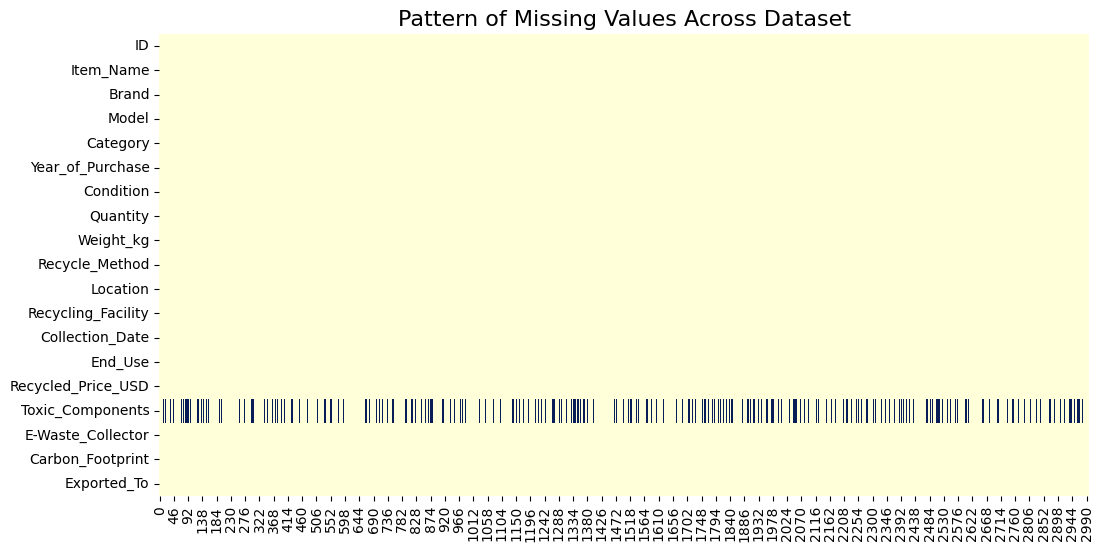

In [5]:
# Analyze missingness by category
toxic_missing_by_category = df_clean[df_clean['Toxic_Components'].isna()]['Category'].value_counts(normalize=True)
print("Percentage of missing Toxic_Components by category:")
print(toxic_missing_by_category)

# Check if missingness is random or follows a pattern
plt.figure(figsize=(12,6))
sns.heatmap(df_clean.isnull().transpose(), cmap='YlGnBu', cbar=False)
plt.title('Pattern of Missing Values Across Dataset', fontsize=16)
plt.show()

## Exploratory Data Analysis (EDA)

### A. Composition Analysis

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\3225423601.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_dist.values, y=category_dist.index, palette='viridis')


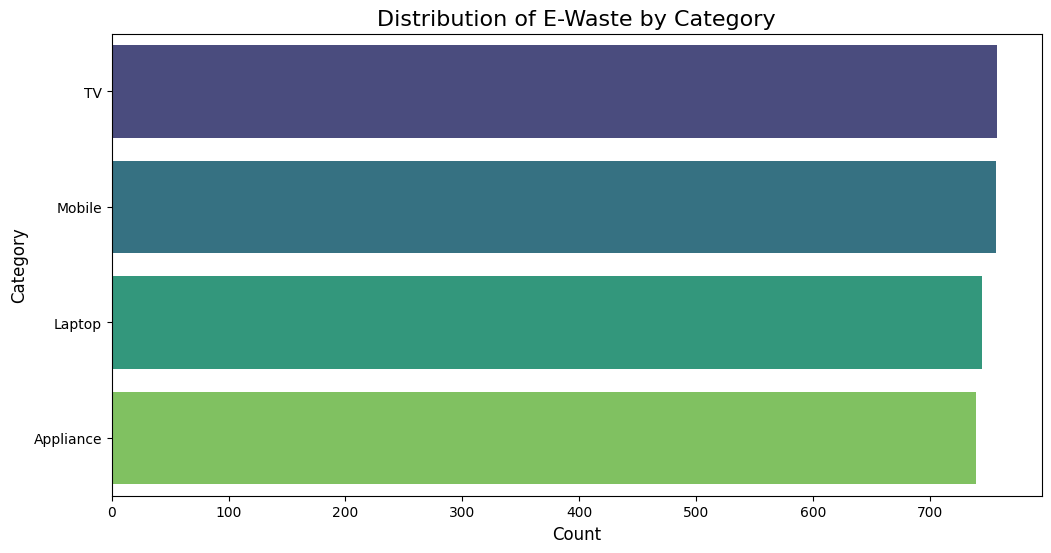

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\3225423601.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')


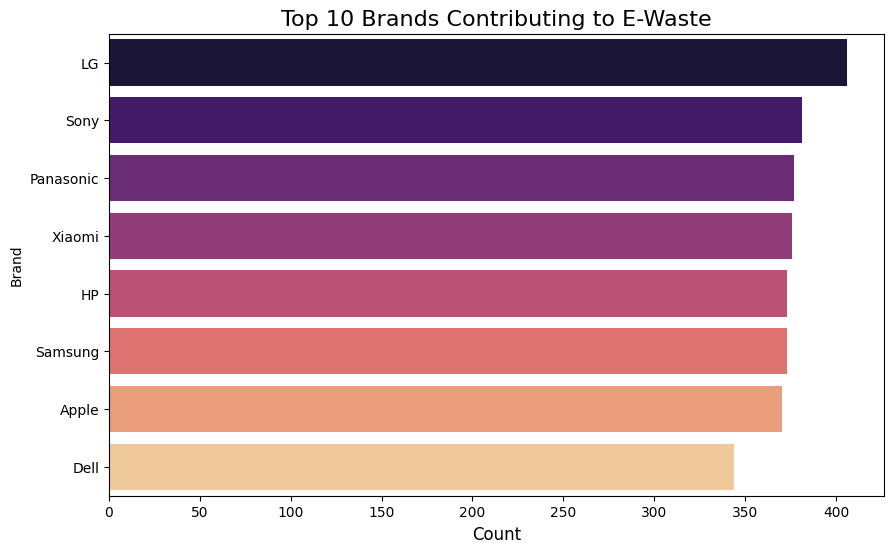

In [6]:
# 1. E-waste by category
plt.figure(figsize=(12,6))
category_dist = df_clean['Category'].value_counts()
sns.barplot(x=category_dist.values, y=category_dist.index, palette='viridis')
plt.title('Distribution of E-Waste by Category', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

# 2. Top brands contributing to e-waste
plt.figure(figsize=(10,6))
top_brands = df_clean['Brand'].value_counts().nlargest(10)
sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')
plt.title('Top 10 Brands Contributing to E-Waste', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.show()

1. DESCRIPTIVE STATISTICS WITH VISUALIZATIONS


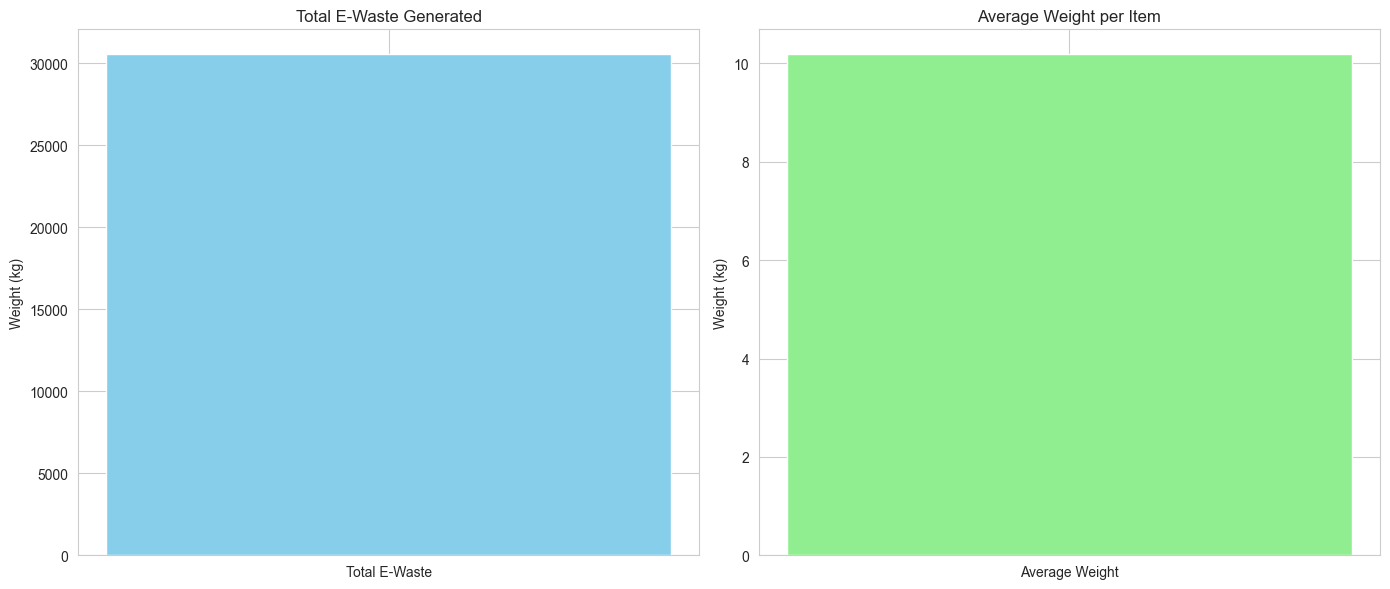

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_counts.values, y=brand_counts.index, palette='magma')


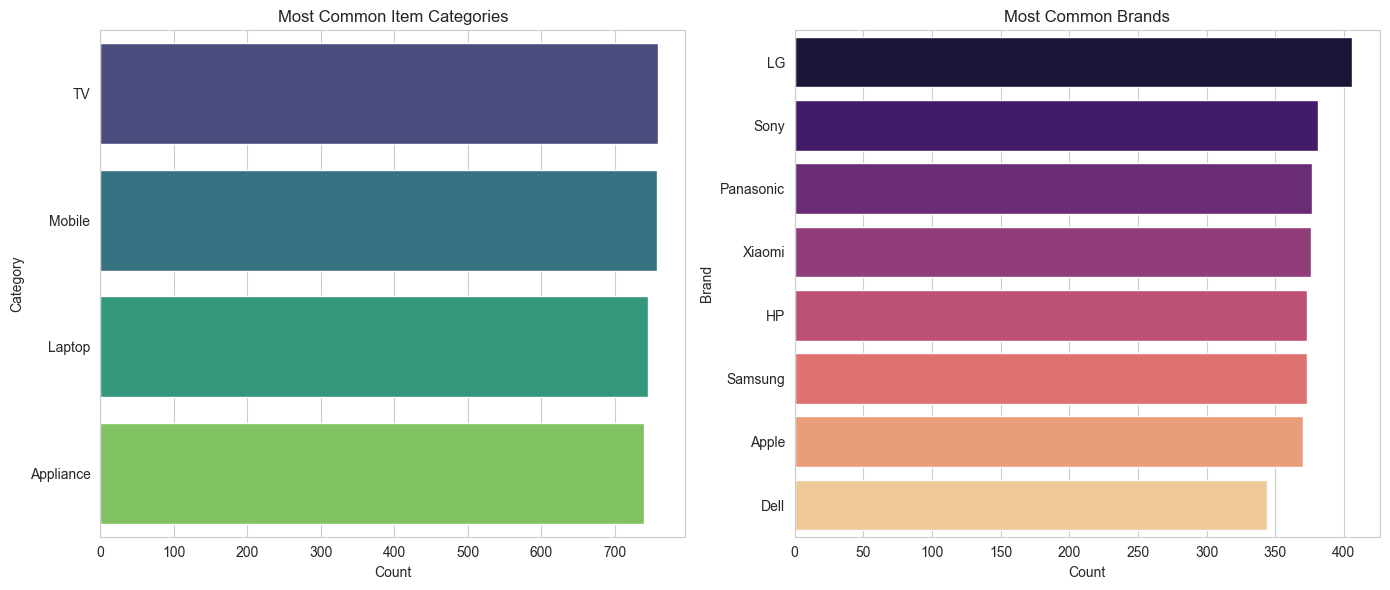

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Condition', order=condition_counts.index, palette='Set2')


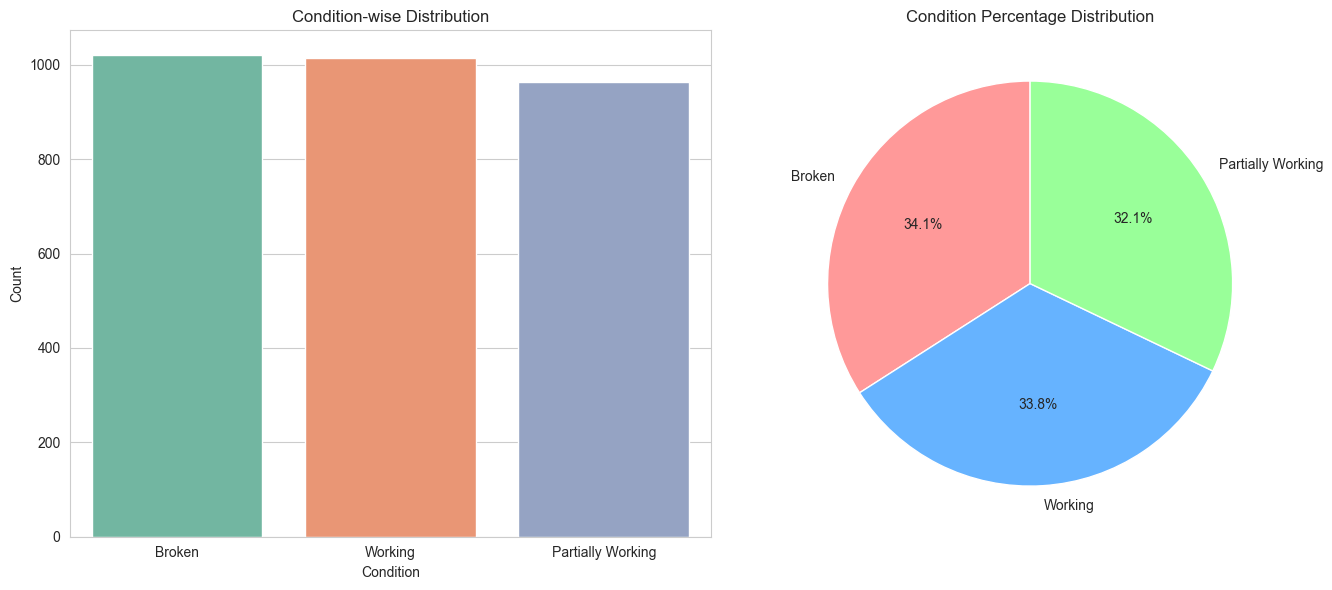

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Year_of_Purchase', palette='coolwarm')


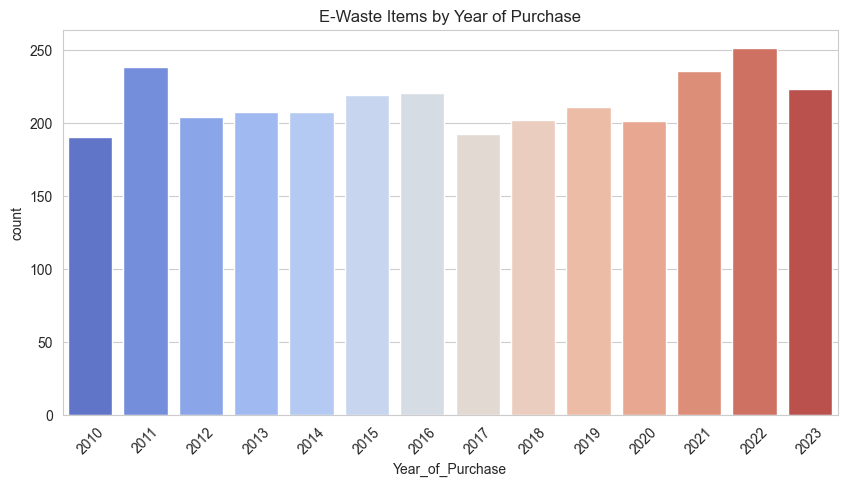

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=method_counts.index, y=method_counts.values, palette='rocket')
C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=end_use_counts.index, y=end_use_counts.values, palette='mako')


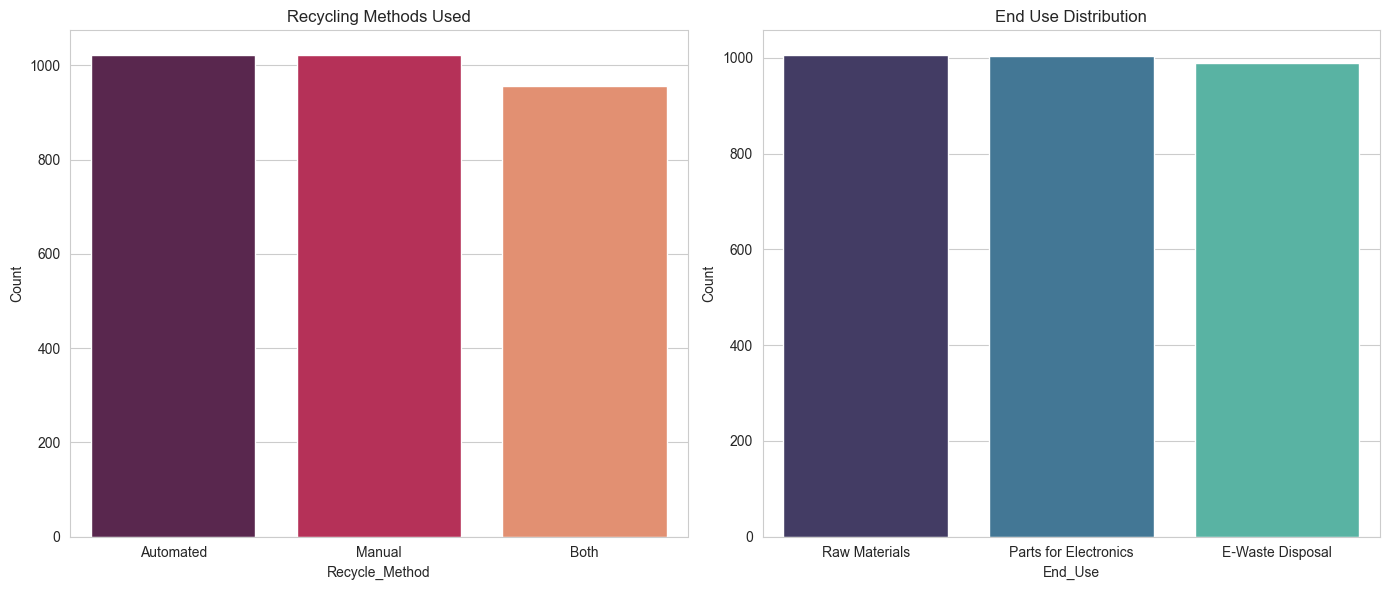

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxic_counts.index, y=toxic_counts.values, palette='YlOrRd')


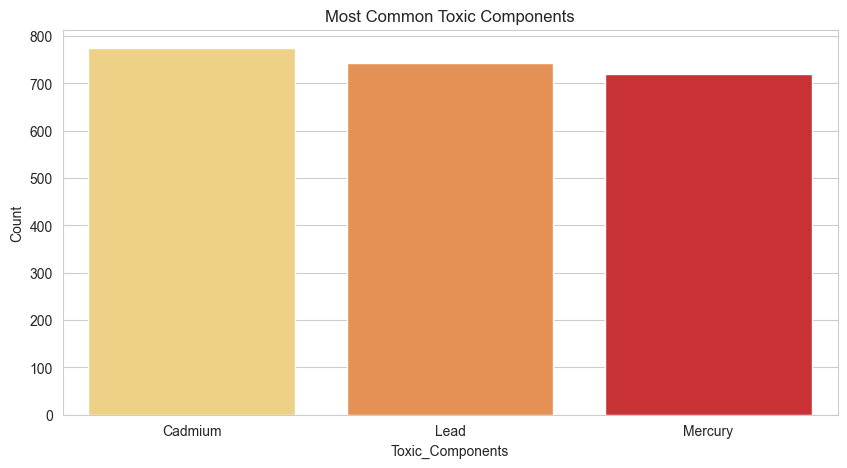

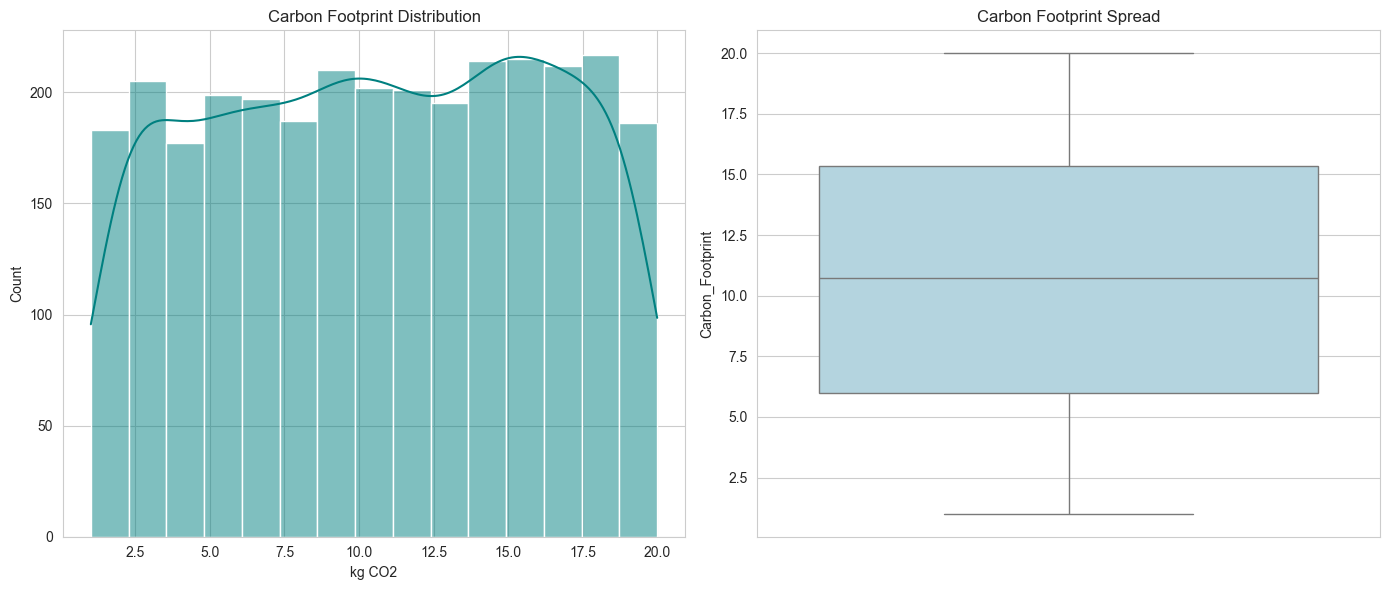

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=export_counts.index, y=export_counts.values, palette='flare')


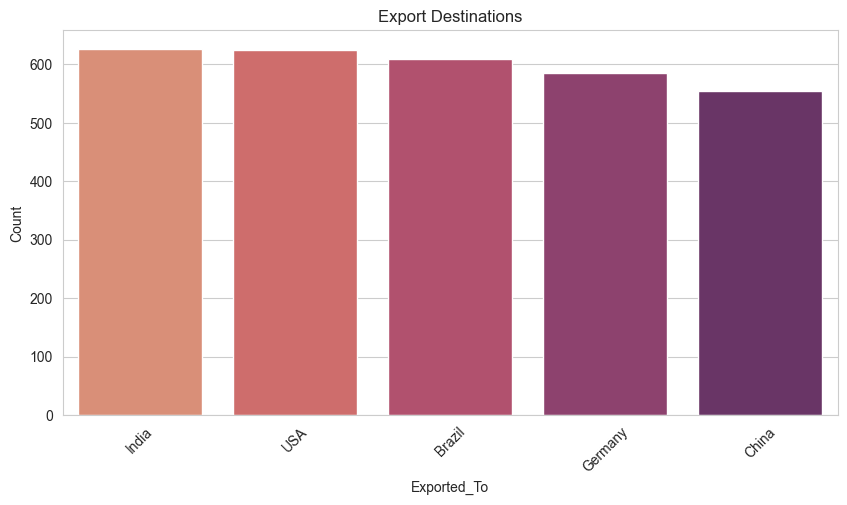

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\1449635754.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Recycled_Price_USD', palette='Set3')


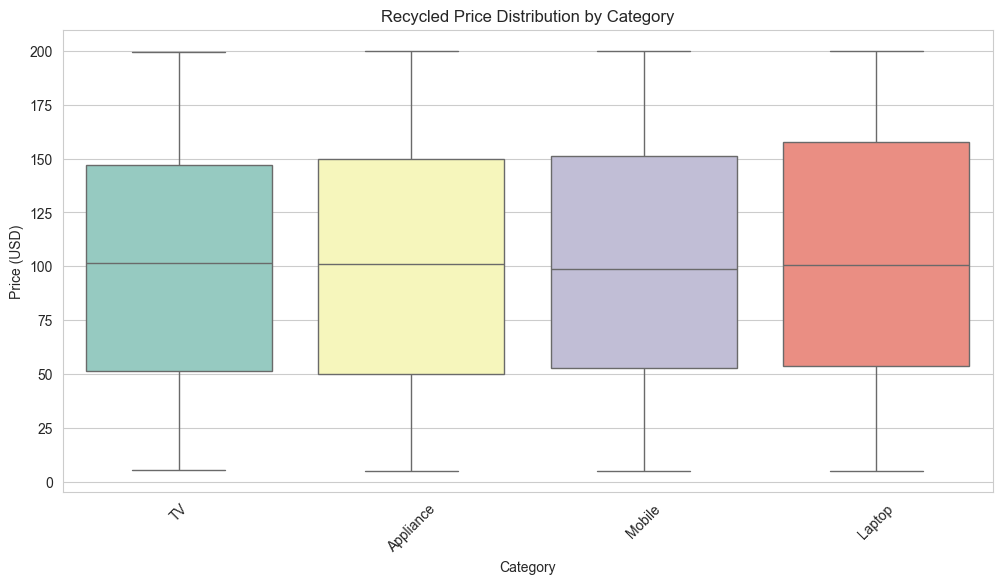

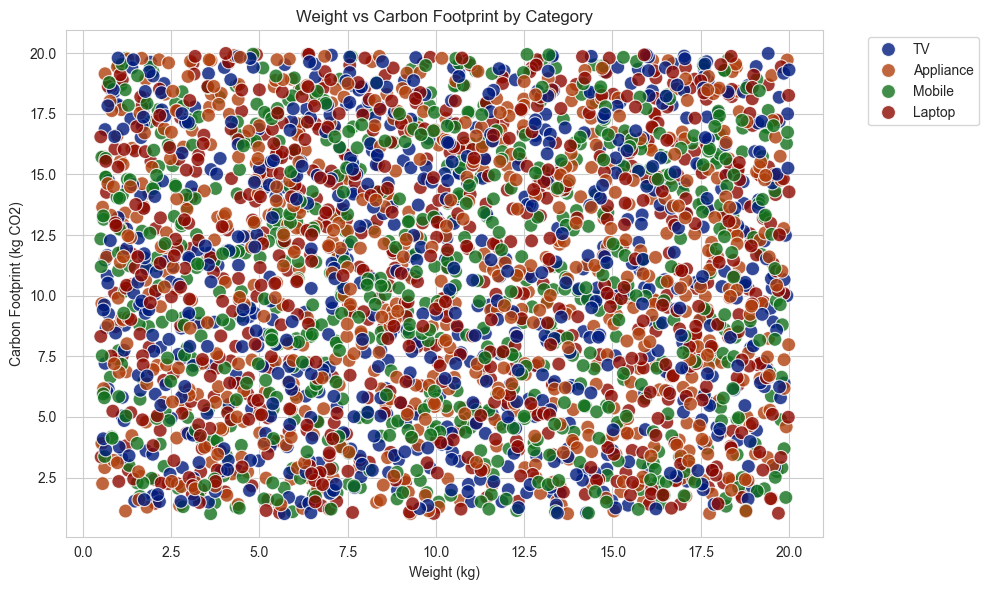

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Descriptive Statistics with Visualizations

print("="*50)
print("1. DESCRIPTIVE STATISTICS WITH VISUALIZATIONS")
print("="*50)

# 1.1 Total and Average Weight Visualization
total_ewaste = df['Weight_kg'].sum()
avg_weight = df['Weight_kg'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.bar(['Total E-Waste'], [total_ewaste], color='skyblue')
ax1.set_ylabel('Weight (kg)')
ax1.set_title('Total E-Waste Generated')

ax2.bar(['Average Weight'], [avg_weight], color='lightgreen')
ax2.set_ylabel('Weight (kg)')
ax2.set_title('Average Weight per Item')

plt.tight_layout()
plt.show()

# 1.2 Category and Brand Distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
category_counts = df['Category'].value_counts()
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('Most Common Item Categories')
plt.xlabel('Count')

plt.subplot(1, 2, 2)
brand_counts = df['Brand'].value_counts()
sns.barplot(x=brand_counts.values, y=brand_counts.index, palette='magma')
plt.title('Most Common Brands')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

# 1.3 Condition Breakdown with Pie Chart
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
condition_counts = df['Condition'].value_counts()
sns.countplot(data=df, x='Condition', order=condition_counts.index, palette='Set2')
plt.title('Condition-wise Distribution')
plt.xlabel('Condition')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff','#99ff99'], startangle=90)
plt.title('Condition Percentage Distribution')
plt.tight_layout()
plt.show()

# 1.4 Year of Purchase Analysis
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Year_of_Purchase', palette='coolwarm')
plt.title('E-Waste Items by Year of Purchase')
plt.xticks(rotation=45)
plt.show()

# 1.5 Recycling Method and End Use
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
method_counts = df['Recycle_Method'].value_counts()
sns.barplot(x=method_counts.index, y=method_counts.values, palette='rocket')
plt.title('Recycling Methods Used')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
end_use_counts = df['End_Use'].value_counts()
sns.barplot(x=end_use_counts.index, y=end_use_counts.values, palette='mako')
plt.title('End Use Distribution')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 1.6 Toxic Components Analysis
plt.figure(figsize=(10, 5))
toxic_counts = df['Toxic_Components'].value_counts()
sns.barplot(x=toxic_counts.index, y=toxic_counts.values, palette='YlOrRd')
plt.title('Most Common Toxic Components')
plt.ylabel('Count')
plt.show()

# 1.7 Carbon Footprint Analysis
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Carbon_Footprint'], bins=15, kde=True, color='teal')
plt.title('Carbon Footprint Distribution')
plt.xlabel('kg CO2')

plt.subplot(1, 2, 2)
sns.boxplot(y='Carbon_Footprint', data=df, color='lightblue')
plt.title('Carbon Footprint Spread')
plt.tight_layout()
plt.show()

# 1.8 Export Destinations
plt.figure(figsize=(10, 5))
export_counts = df['Exported_To'].value_counts()
sns.barplot(x=export_counts.index, y=export_counts.values, palette='flare')
plt.title('Export Destinations')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 1.9 Price Distribution by Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Recycled_Price_USD', palette='Set3')
plt.title('Recycled Price Distribution by Category')
plt.xticks(rotation=45)
plt.ylabel('Price (USD)')
plt.show()

# 1.10 Weight vs Carbon Footprint
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Weight_kg', y='Carbon_Footprint', hue='Category', 
                palette='dark', alpha=0.8, s=100)
plt.title('Weight vs Carbon Footprint by Category')
plt.xlabel('Weight (kg)')
plt.ylabel('Carbon Footprint (kg CO2)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

1. DESCRIPTIVE STATISTICS

Total E-Waste Generated: 30548.40 kg

Average Weight per Item: 10.18 kg

Most Common Item Categories:
Category
TV           758
Mobile       757
Laptop       745
Appliance    740
Name: count, dtype: int64

Most Common Brands:
Brand
LG           406
Sony         381
Panasonic    377
Xiaomi       376
HP           373
Name: count, dtype: int64

Condition-wise Breakdown:
Condition
Broken               1022
Working              1015
Partially Working     963
Name: count, dtype: int64


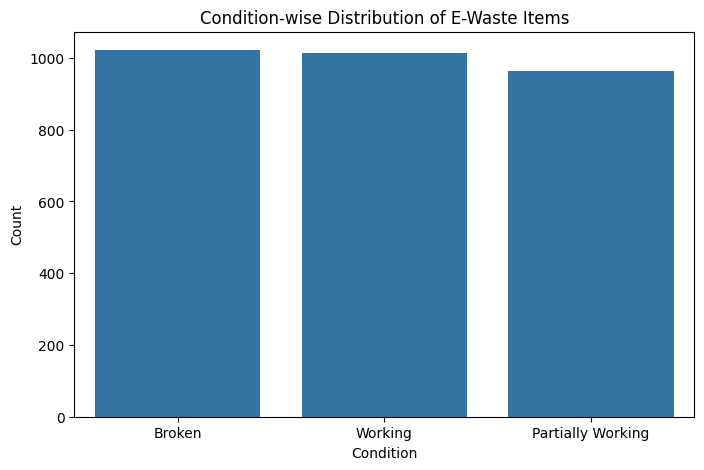


Additional Statistics:

Year of Purchase Range: 2010 to 2023

Recycling Methods Used:
Recycle_Method
Automated    1023
Manual       1021
Both          956
Name: count, dtype: int64

Top Recycling Facilities:
Recycling_Facility
Facility A    760
Facility C    753
Facility D    746
Facility B    741
Name: count, dtype: int64

End Use Distribution:
End_Use
Raw Materials            1007
Parts for Electronics    1004
E-Waste Disposal          989
Name: count, dtype: int64

Average Recycled Price: $101.50

Most Common Toxic Components:
Toxic_Components
Cadmium    775
Lead       743
Mercury    719
Name: count, dtype: int64

Carbon Footprint Analysis:
Average Carbon Footprint per item: 10.66 kg CO2
Total Carbon Footprint: 31982.01 kg CO2

Export Destinations:
Exported_To
India      627
USA        624
Brazil     609
Germany    586
China      554
Name: count, dtype: int64


In [7]:
# 1. Descriptive Statistics

print("="*50)
print("1. DESCRIPTIVE STATISTICS")
print("="*50)

# Total e-waste generated (sum of Weight_kg)
total_ewaste = df['Weight_kg'].sum()
print(f"\nTotal E-Waste Generated: {total_ewaste:.2f} kg")

# Average weight per item
avg_weight = df['Weight_kg'].mean()
print(f"\nAverage Weight per Item: {avg_weight:.2f} kg")

# Most common item categories
print("\nMost Common Item Categories:")
print(df['Category'].value_counts().head())

# Most common brands
print("\nMost Common Brands:")
print(df['Brand'].value_counts().head())

# Condition-wise breakdown
print("\nCondition-wise Breakdown:")
condition_counts = df['Condition'].value_counts()
print(condition_counts)

# Visualization of condition breakdown
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Condition', order=condition_counts.index)
plt.title('Condition-wise Distribution of E-Waste Items')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

# Additional useful statistics
print("\nAdditional Statistics:")
print(f"\nYear of Purchase Range: {df['Year_of_Purchase'].min()} to {df['Year_of_Purchase'].max()}")
print(f"\nRecycling Methods Used:")
print(df['Recycle_Method'].value_counts())
print(f"\nTop Recycling Facilities:")
print(df['Recycling_Facility'].value_counts().head())
print(f"\nEnd Use Distribution:")
print(df['End_Use'].value_counts())
print(f"\nAverage Recycled Price: ${df['Recycled_Price_USD'].mean():.2f}")
print(f"\nMost Common Toxic Components:")
print(df['Toxic_Components'].value_counts().head())

# Carbon footprint analysis
print("\nCarbon Footprint Analysis:")
print(f"Average Carbon Footprint per item: {df['Carbon_Footprint'].mean():.2f} kg CO2")
print(f"Total Carbon Footprint: {df['Carbon_Footprint'].sum():.2f} kg CO2")

# Export destinations
print("\nExport Destinations:")
print(df['Exported_To'].value_counts())

In [16]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import time

# 1. Data Preparation
# Ensure we have the required columns
if not all(col in df.columns for col in ['Location', 'Exported_To', 'Weight_kg']):
    raise ValueError("CSV file must contain 'Location', 'Exported_To', and 'Weight_kg' columns")

# Create a mapping from cities to their countries (you may need to customize this)
# This is a simple example - you might need a more comprehensive mapping
city_to_country = {
    'CityA': 'United States',  # Example mapping
    'CityB': 'Germany',
    'CityC': 'Japan',
    # Add all your locations and their respective countries
}

# Add origin country column
df['Origin_Country'] = df['Location'].map(city_to_country)

# Handle any missing mappings
if df['Origin_Country'].isnull().any():
    missing_locations = df[df['Origin_Country'].isnull()]['Location'].unique()
    print(f"Warning: Missing country mapping for locations: {', '.join(missing_locations)}")
    # Fill with a default or investigate these cases
    df['Origin_Country'] = df['Origin_Country'].fillna('Unknown')

# 2. Geocoding Setup
geolocator = Nominatim(user_agent="ewaste_flow_analysis")

# Cache for coordinates to avoid repeated API calls
coordinate_cache = {}

def get_coordinates(place):
    if place in coordinate_cache:
        return coordinate_cache[place]
    
    try:
        location = geolocator.geocode(place)
        if location:
            coords = {'lat': location.latitude, 'lon': location.longitude}
            coordinate_cache[place] = coords
            return coords
        else:
            print(f"Could not geocode: {place}")
            return {'lat': 0, 'lon': 0}  # Default coordinates
    except:
        print(f"Geocoding failed for: {place}")
        return {'lat': 0, 'lon': 0}

# 3. Data Aggregation
flow_data = df.groupby(['Location', 'Exported_To']).agg(
    Total_Weight=('Weight_kg', 'sum'),
    Shipment_Count=('Weight_kg', 'count')
).reset_index()

# Get unique countries for geocoding
all_countries = set(flow_data['Location']).union(set(flow_data['Exported_To']))

print("Geocoding countries... (this may take a while)")
for country in all_countries:
    get_coordinates(country)
    time.sleep(1)  # Be polite to the geocoding service

# 4. Create the Flow Map
fig = go.Figure()

# Add flows for each origin-destination pair
for i, row in flow_data.iterrows():
    origin_coords = get_coordinates(row['Location'])
    dest_coords = get_coordinates(row['Exported_To'])
    
    fig.add_trace(
        go.Scattergeo(
            lon = [origin_coords['lon'], dest_coords['lon']],
            lat = [origin_coords['lat'], dest_coords['lat']],
            mode = 'lines',
            line = dict(
                width = row['Total_Weight']/flow_data['Total_Weight'].max() * 10 + 1,
                color = 'red',
            ),
            opacity = 0.6,
            hoverinfo = 'text',
            text = (f"From {row['Location']} to {row['Exported_To']}<br>"
                    f"Total Weight: {row['Total_Weight']:.2f} kg<br>"
                    f"Shipments: {row['Shipment_Count']}"),
            showlegend = False
        )
    )

# Add origin markers
fig.add_trace(
    go.Scattergeo(
        lon = [get_coordinates(c)['lon'] for c in flow_data['Location'].unique()],
        lat = [get_coordinates(c)['lat'] for c in flow_data['Location'].unique()],
        hoverinfo = 'text',
        text = flow_data['Location'].unique(),
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'blue',
            line = dict(width=1, color='white')
        ),
        name = 'Origin Countries'
    )
)

# Add destination markers
fig.add_trace(
    go.Scattergeo(
        lon = [get_coordinates(c)['lon'] for c in flow_data['Exported_To'].unique()],
        lat = [get_coordinates(c)['lat'] for c in flow_data['Exported_To'].unique()],
        hoverinfo = 'text',
        text = flow_data['Exported_To'].unique(),
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'green',
            line = dict(width=1, color='white')
        ),
        name = 'Export Destinations'
    )
)

# Update layout
fig.update_layout(
    title_text = 'E-Waste Export Flow Analysis',
    showlegend = True,
    geo = dict(
        scope = 'world',
        projection_type = 'natural earth',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    margin = dict(l=0, r=0, t=40, b=0)
)

# 5. Additional Metrics Table
print("\nExport Flow Summary:")
print(flow_data.sort_values('Total_Weight', ascending=False).to_string(index=False))

# 6. Show the figure
fig.show()

# 7. Save the visualization
fig.write_html("e_waste_export_flow.html")
print("Visualization saved as 'e_waste_export_flow.html'")

Geocoding countries... (this may take a while)

Export Flow Summary:
Location Exported_To  Total_Weight  Shipment_Count
  Berlin         USA       1333.09             119
   Dhaka       India       1214.68             113
  Mumbai       China       1156.01             111
  London     Germany       1141.01             103
New York       India       1137.33             112
Shanghai         USA       1129.00             107
   Dhaka      Brazil       1105.64             109
  Mumbai       India       1085.63             104
  Mumbai      Brazil       1066.13             101
  London       India       1056.31             105
  Mumbai         USA       1046.76             104
   Dhaka         USA       1045.96              99
New York         USA       1039.10              96
  London         USA       1024.86              99
New York     Germany       1010.56              98
Shanghai       India       1009.70             104
  Berlin       China       1003.95              97
  Berlin     

Visualization saved as 'e_waste_export_flow.html'


In [19]:
import pandas as pd
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import time
from tqdm import tqdm


# 1. Data Preparation
print("\n🔍 Preparing data...")

# Sample city to country mapping - REPLACE WITH YOUR ACTUAL MAPPING
city_to_country = {
    'New York': 'United States',
    'Berlin': 'Germany',
    'Tokyo': 'Japan',
    'London': 'United Kingdom',
    'Paris': 'France',
    'Mumbai': 'India',
    'Shanghai': 'China',
    'Sydney': 'Australia',
    'Toronto': 'Canada',
    'São Paulo': 'Brazil'
}

# Fill missing mappings with city names
df['Origin_Country'] = df['Location'].map(city_to_country).fillna(df['Location'])

# 2. Geocoding Setup
print("\n🌍 Geocoding locations...")
geolocator = Nominatim(user_agent="ewaste_flow_analysis_v3")
coordinate_cache = {}

def get_coordinates(place):
    if place in coordinate_cache:
        return coordinate_cache[place]
    
    try:
        location = geolocator.geocode(place)
        time.sleep(1.1)  # Respect rate limits
        if location:
            coords = {'lat': location.latitude, 'lon': location.longitude}
            coordinate_cache[place] = coords
            return coords
        return {'lat': 0, 'lon': 0}
    except Exception as e:
        print(f"⚠️ Could not geocode {place}: {str(e)}")
        return {'lat': 0, 'lon': 0}

# 3. Data Processing
print("\n📊 Processing data...")

# Aggregate data
flow_data = df.groupby(['Location', 'Exported_To']).agg(
    Total_Weight=('Weight_kg', 'sum'),
    Shipment_Count=('Weight_kg', 'count')
).reset_index()

# Get unique locations
all_places = list(flow_data['Location'].unique()) + list(flow_data['Exported_To'].unique())

# Geocode with progress bar
print("⏳ Geocoding progress:")
for place in tqdm(all_places):
    get_coordinates(place)

# 4. Create Visualization
print("\n🎨 Creating visualization...")

# Create figure
fig = go.Figure(layout=go.Layout(
    width=1400,
    height=800,
    autosize=False
))

# Color scale for flows
color_scale = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Add flow lines
for i, row in flow_data.iterrows():
    origin = get_coordinates(row['Location'])
    dest = get_coordinates(row['Exported_To'])
    
    fig.add_trace(go.Scattergeo(
        lon = [origin['lon'], dest['lon']],
        lat = [origin['lat'], dest['lat']],
        mode = 'lines',
        line = dict(
            width = 0.5 + (row['Total_Weight'] / flow_data['Total_Weight'].max() * 5),
            color = color_scale[i % len(color_scale)],
        ),
        opacity = 0.7,
        hoverinfo = 'text',
        text = (f"<b>From:</b> {row['Location']}<br>"
                f"<b>To:</b> {row['Exported_To']}<br>"
                f"<b>Total Weight:</b> {row['Total_Weight']:,.2f} kg<br>"
                f"<b>Shipments:</b> {row['Shipment_Count']}"),
        showlegend = False
    ))

# Add origin markers
fig.add_trace(go.Scattergeo(
    lon = [get_coordinates(loc)['lon'] for loc in flow_data['Location'].unique()],
    lat = [get_coordinates(loc)['lat'] for loc in flow_data['Location'].unique()],
    mode = 'markers',
    marker = dict(
        size = 12,
        color = '#4285F4',
        line = dict(width=2, color='white')
    ),
    text = flow_data['Location'].unique(),
    hoverinfo = 'text',
    name = 'Collection Points'
))

# Add destination markers
fig.add_trace(go.Scattergeo(
    lon = [get_coordinates(dest)['lon'] for dest in flow_data['Exported_To'].unique()],
    lat = [get_coordinates(dest)['lat'] for dest in flow_data['Exported_To'].unique()],
    mode = 'markers',
    marker = dict(
        size = 12,
        color = '#EA4335',
        symbol = 'diamond',
        line = dict(width=2, color='white')
    ),
    text = flow_data['Exported_To'].unique(),
    hoverinfo = 'text',
    name = 'Export Destinations'
))

# Update layout
fig.update_layout(
    title = dict(
        text = '<b>Global E-Waste Export Flows</b>',
        font = dict(size=24, family="Arial Black"),
        x = 0.5,
        xanchor = 'center'
    ),
    geo = dict(
        scope = 'world',
        projection_type = 'natural earth',
        showland = True,
        landcolor = 'rgb(240, 240, 240)',
        countrycolor = 'rgb(200, 200, 200)',
        showocean = True,
        oceancolor = 'rgb(220, 240, 255)',
        showcountries = True,
        showframe = False
    ),
    margin = dict(l=10, r=10, t=80, b=0),
    hoverlabel = dict(
        bgcolor = 'white',
        font_size = 14,
        font_family = 'Arial'
    ),
    plot_bgcolor = 'rgb(250, 250, 250)',
    paper_bgcolor = 'rgb(250, 250, 250)'
)

# 5. Save and display
print("\n💾 Saving visualization...")
fig.write_html("e_waste_export_flow.html")
print("✅ Saved as 'e_waste_export_flow.html'")

print("\n🖥️ Displaying visualization...")
fig.show()


🔍 Preparing data...

🌍 Geocoding locations...

📊 Processing data...
⏳ Geocoding progress:


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


🎨 Creating visualization...

💾 Saving visualization...
✅ Saved as 'e_waste_export_flow.html'

🖥️ Displaying visualization...


### B. Temporal Trends

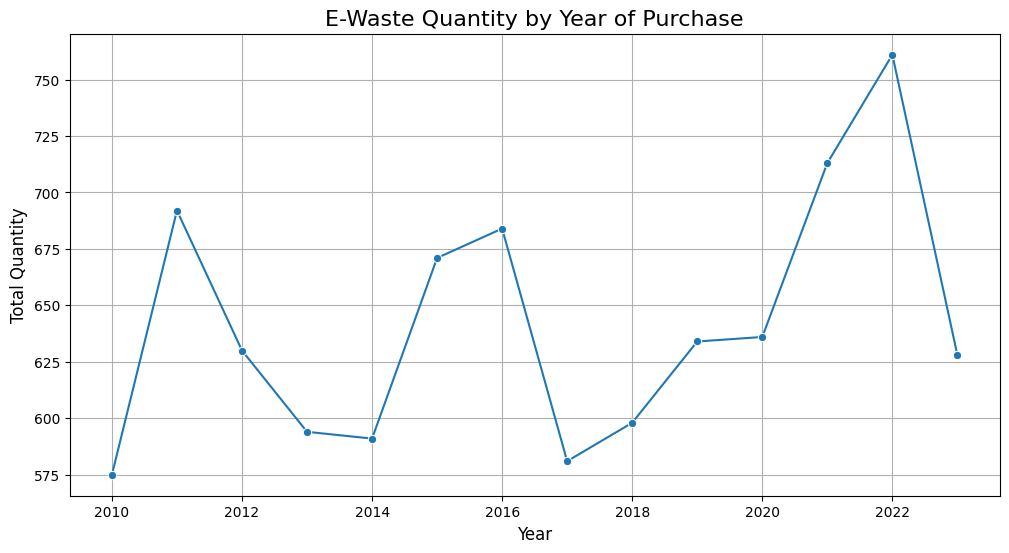

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\3628114843.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_trend.index, y=monthly_trend.values, palette='coolwarm')


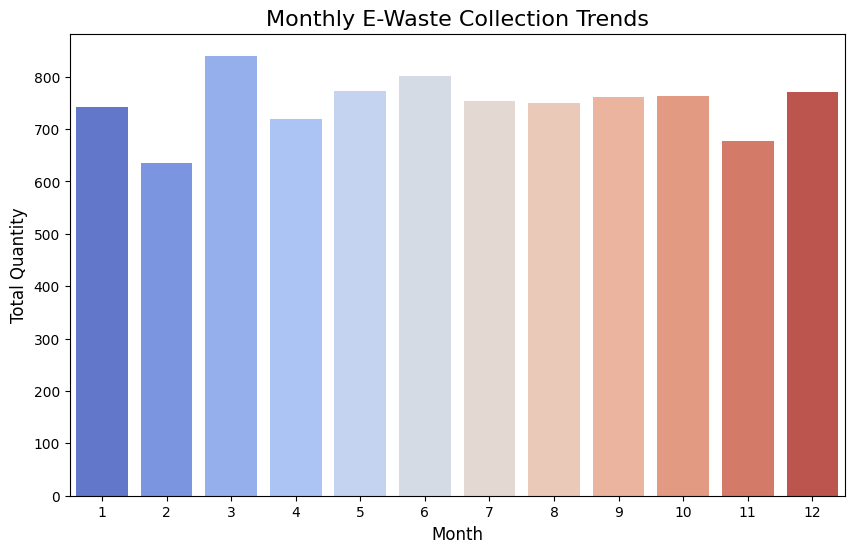

In [8]:
# 1. E-waste by year of purchase
plt.figure(figsize=(12,6))
year_trend = df_clean.groupby('Year_of_Purchase')['Quantity'].sum()
sns.lineplot(x=year_trend.index, y=year_trend.values, marker='o')
plt.title('E-Waste Quantity by Year of Purchase', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.grid(True)
plt.show()

# 2. Monthly collection trends (if data spans multiple years)
df_clean['Collection_Month'] = df_clean['Collection_Date'].dt.month
monthly_trend = df_clean.groupby('Collection_Month')['Quantity'].sum()
plt.figure(figsize=(10,6))
sns.barplot(x=monthly_trend.index, y=monthly_trend.values, palette='coolwarm')
plt.title('Monthly E-Waste Collection Trends', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.show()

### C. Value and Environmental Impact Analysis

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\2923469527.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_by_category.values, y=price_by_category.index, palette='plasma')


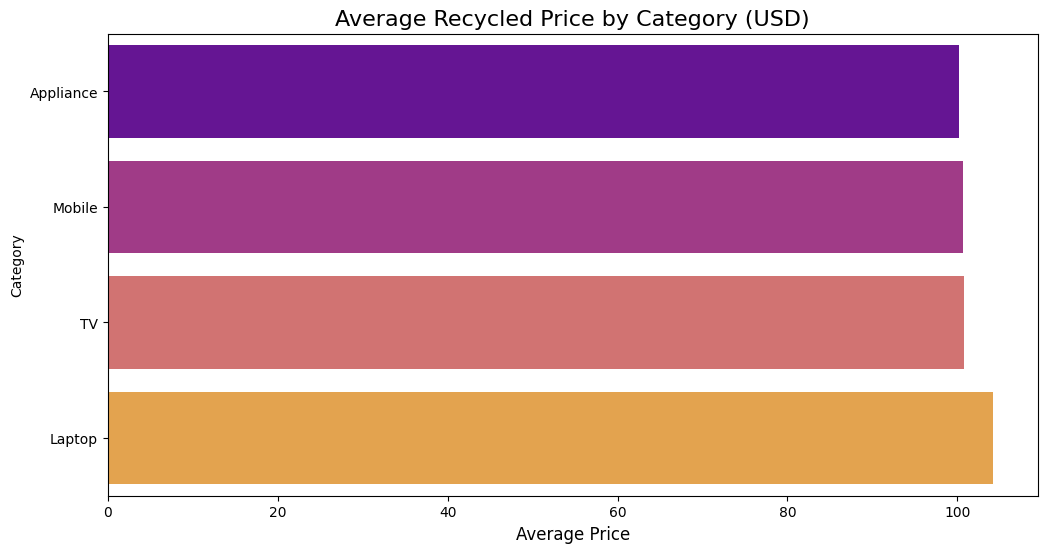

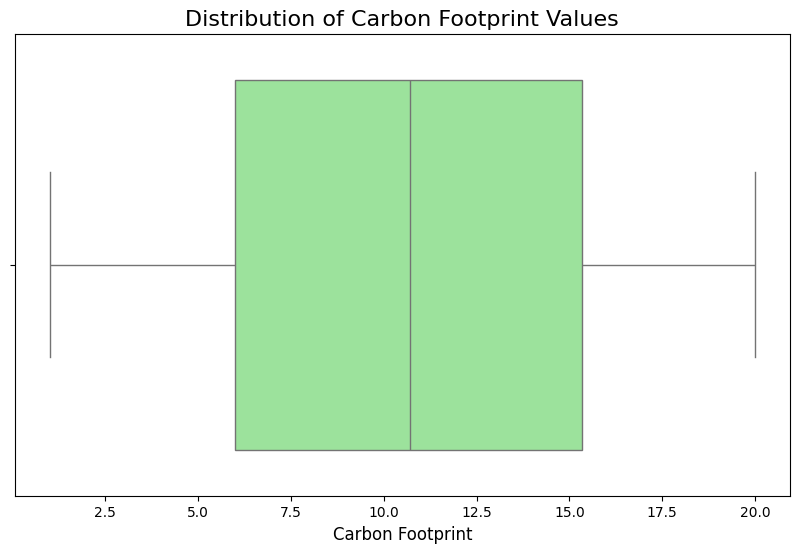

C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\2923469527.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxic_counts.values, y=toxic_counts.index, palette='YlOrRd')


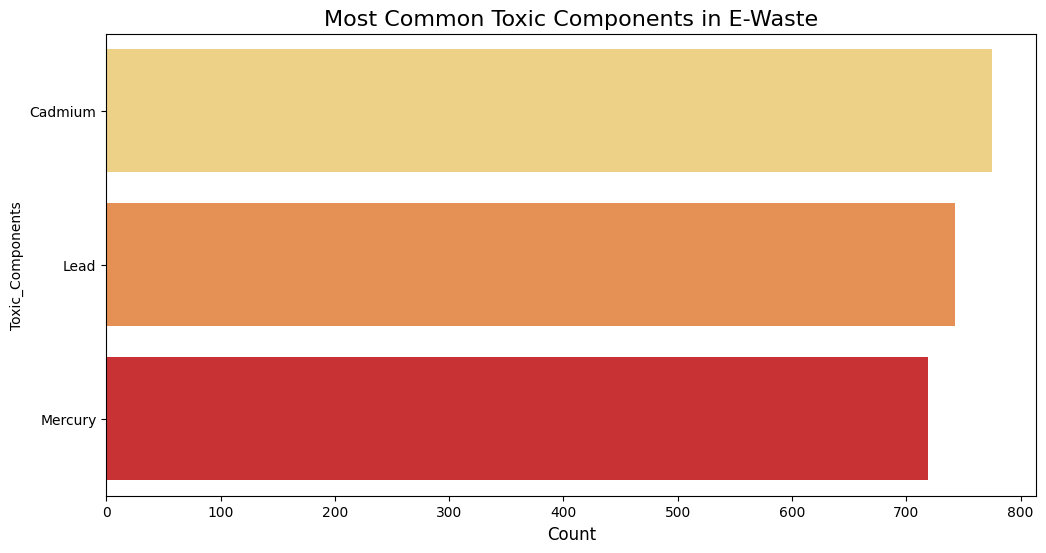

In [9]:
# 1. Average recycled price by category
plt.figure(figsize=(12,6))
price_by_category = df_clean.groupby('Category')['Recycled_Price_USD'].mean().sort_values()
sns.barplot(x=price_by_category.values, y=price_by_category.index, palette='plasma')
plt.title('Average Recycled Price by Category (USD)', fontsize=16)
plt.xlabel('Average Price', fontsize=12)
plt.show()

# 2. Carbon footprint distribution
plt.figure(figsize=(10,6))
sns.boxplot(x=df_clean['Carbon_Footprint'], color='lightgreen')
plt.title('Distribution of Carbon Footprint Values', fontsize=16)
plt.xlabel('Carbon Footprint', fontsize=12)
plt.show()

# 3. Toxic components analysis
toxic_counts = df_clean['Toxic_Components'].str.split(',').explode().value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=toxic_counts.values, y=toxic_counts.index, palette='YlOrRd')
plt.title('Most Common Toxic Components in E-Waste', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.show()

## Correlation Analysis

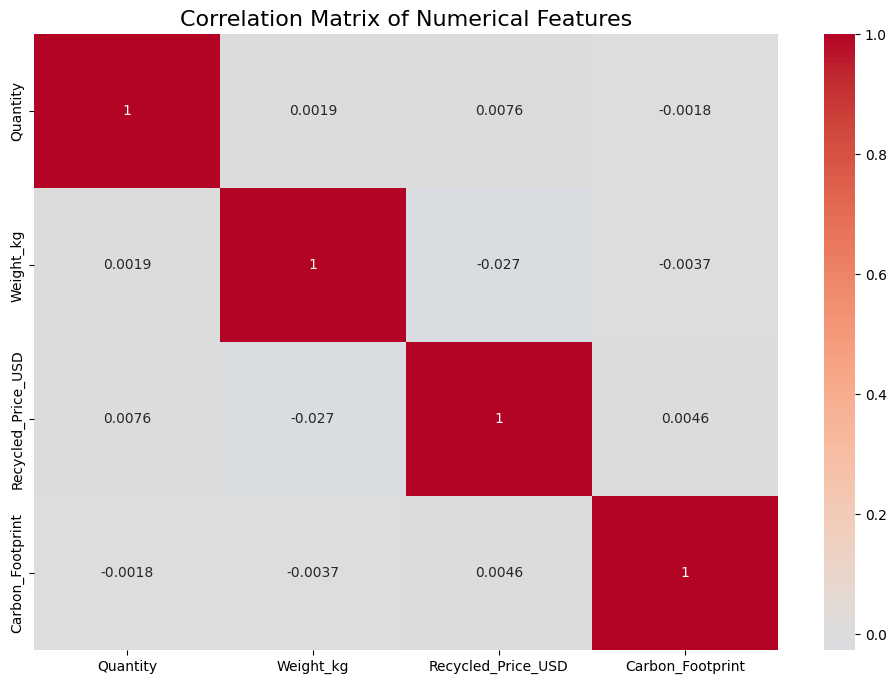

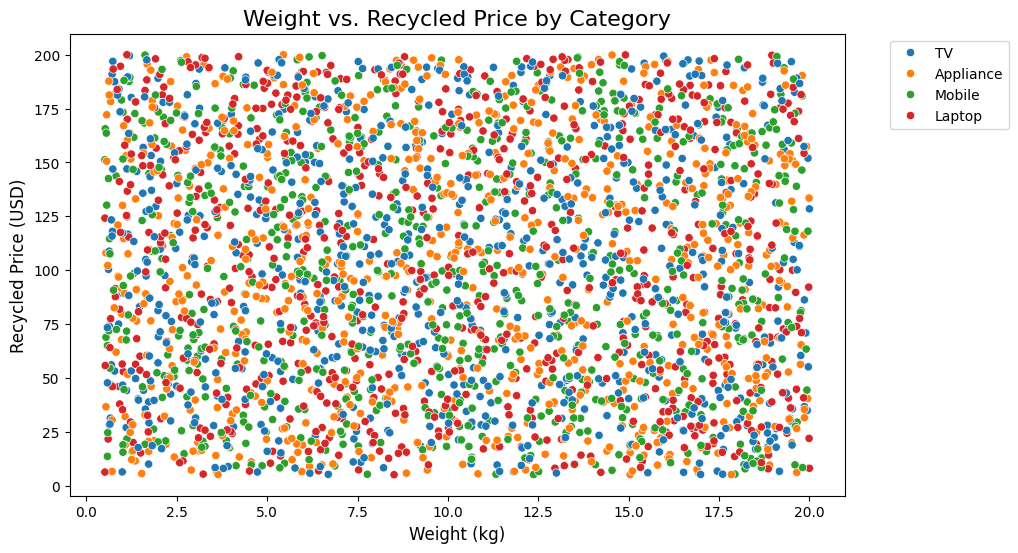

In [10]:
# Select numerical features for correlation
num_features = df_clean.select_dtypes(include=['int64','float64']).drop(columns=['ID','Year_of_Purchase'])

# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(num_features.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

# Scatter plot of key relationships
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='Weight_kg', y='Recycled_Price_USD', hue='Category')
plt.title('Weight vs. Recycled Price by Category', fontsize=16)
plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Recycled Price (USD)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Advanced Analysis (Machine Learning)

#### A. Price Prediction Model 

Model R-squared: -0.08
Root Mean Squared Error: 58.76


C:\Users\harsh\AppData\Local\Temp\ipykernel_4936\2948722995.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


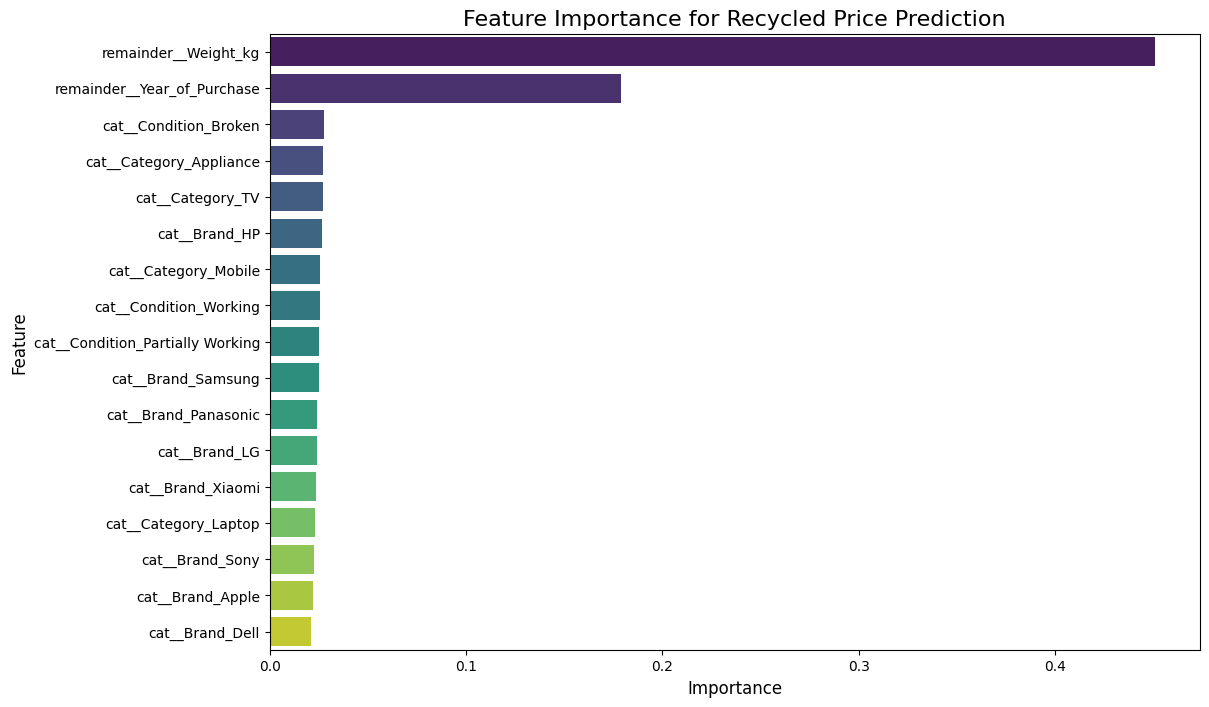

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Prepare data for modeling
X = df_clean[['Category', 'Brand', 'Condition', 'Weight_kg', 'Year_of_Purchase']]
y = df_clean['Recycled_Price_USD']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Category', 'Brand', 'Condition'])
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# [Previous data preparation code remains the same...]

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate with version-agnostic RMSE calculation
y_pred = model.predict(X_test)
print(f"Model R-squared: {r2_score(y_test, y_pred):.2f}")

# Robust RMSE calculation
try:
    # Try modern syntax first
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except TypeError:
    # Fallback for older versions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
print(f"Root Mean Squared Error: {rmse:.2f}")

# [Rest of your feature importance code...]
# Feature importance (visualization)
importances = model.feature_importances_
features = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Recycled Price Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

#### B. Toxicity Classification

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.10      0.14       153
           1       0.74      0.89      0.81       447

    accuracy                           0.69       600
   macro avg       0.48      0.49      0.47       600
weighted avg       0.61      0.69      0.64       600


Accuracy: 0.69


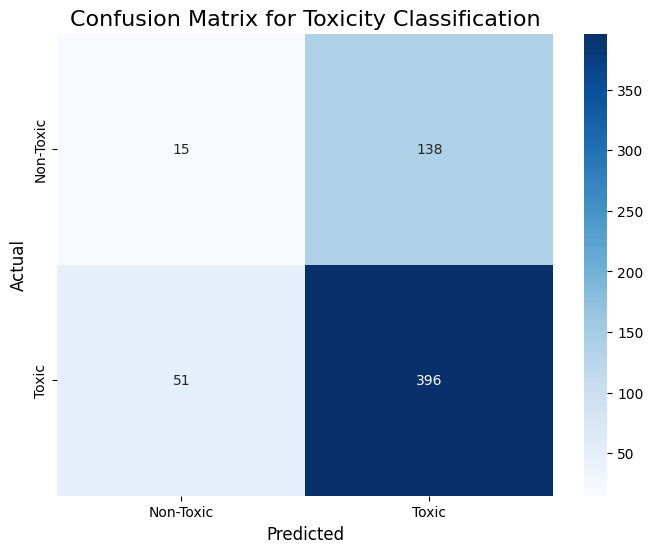

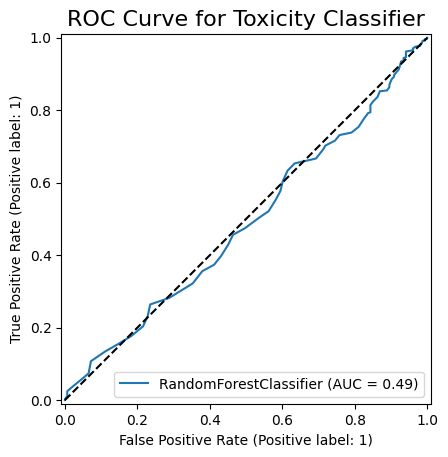

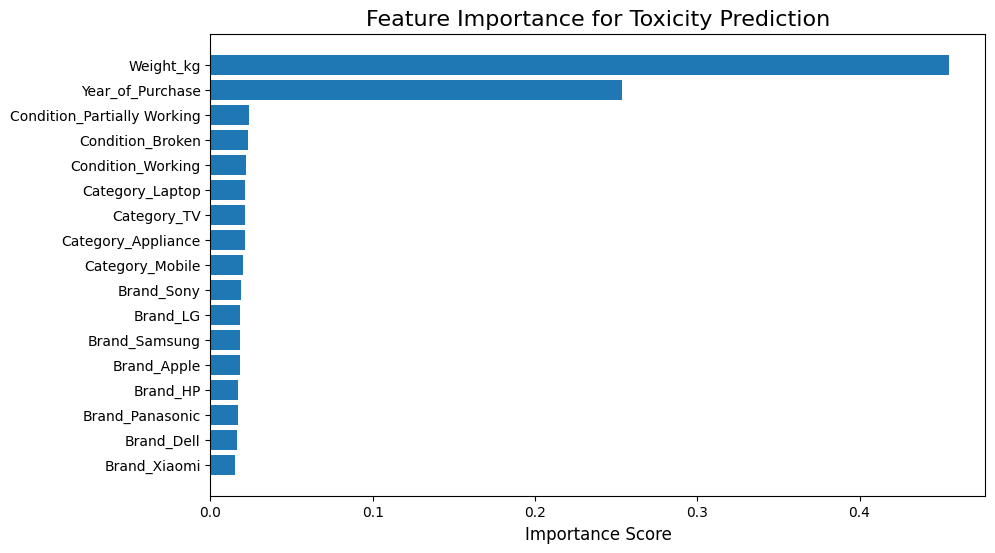

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare the target variable
df_clean['Has_Toxic'] = df_clean['Toxic_Components'].notna().astype(int)

# 2. Prepare features - now including Condition
features = ['Category', 'Brand', 'Year_of_Purchase', 'Weight_kg', 'Condition']
X_tox = df_clean[features]
y_tox = df_clean['Has_Toxic']

# 3. Preprocessing - properly handle categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Category', 'Brand', 'Condition'])
    ],
    remainder='passthrough'  # This will pass through Year_of_Purchase and Weight_kg
)

X_tox_processed = preprocessor.fit_transform(X_tox)

# 4. Split data
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tox_processed, 
    y_tox, 
    test_size=0.2, 
    random_state=42,
    stratify=y_tox  # Important for imbalanced classes
)

# 5. Train model
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handles class imbalance
)
clf.fit(X_train_t, y_train_t)

# 6. Make predictions
y_pred_t = clf.predict(X_test_t)
y_pred_proba_t = clf.predict_proba(X_test_t)[:, 1]  # Probabilities for ROC curve

# 7. Evaluate classification performance
print("Classification Report:")
print(classification_report(y_test_t, y_pred_t))

print(f"\nAccuracy: {accuracy_score(y_test_t, y_pred_t):.2f}")

# 8. Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_t, y_pred_t), 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Confusion Matrix for Toxicity Classification', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# 9. ROC curve
RocCurveDisplay.from_estimator(clf, X_test_t, y_test_t)
plt.title('ROC Curve for Toxicity Classifier', fontsize=16)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.show()

# 10. Feature importance (new addition)
feature_names = (preprocessor.named_transformers_['cat']
                .get_feature_names_out(input_features=['Category', 'Brand', 'Condition']))
feature_names = np.append(feature_names, ['Year_of_Purchase', 'Weight_kg'])

importances = clf.feature_importances_
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.title('Feature Importance for Toxicity Prediction', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.show()

"Toxicity classification was performed using a Random Forest classifier with balanced class weights. The model used product category, brand, condition, age (year of purchase), and weight as predictors. Categorical features were one-hot encoded, while numerical features were used directly. Model performance was evaluated using standard classification metrics including accuracy, precision-recall, and ROC analysis."